https://boosters.pro/champ_11

Вам предстоит предсказать две пары координат (_HOMELAT,_HOMELON,_WORKLAT,_WORKLON): работы и дома. В качестве датасета участникам предоставлены истории транзакций клиентов «Райффайзенбанк».

Участники Raiffeisen Data Cup, мы допустили ошибку в примере решения и файле "sample"(файл пример). В загружаемом ответе сначала должны идти координаты работы (_WORKLAT, _WORKLON), затем дома(_HOMELAT, _HOMELON).

terminal_id - идентификационный номер терминала  
customer_id - идентификационный номер клиента  
amount - количество потраченных средств за транзакцию  
country - страна  
currency - валюта  
mcc - код категории продавца  
transaction_date - дата транзакции  
atm_address - адрес банкомата  
pos_address - адрес установки pos-терминала  
pos_address_lat - адрес установки pos-терминала широта  
pos_address_lon - адрес установки pos-терминала долгота  
work_add_lat - широта работы клиента  
work_add_lon - долгота работы клиента  
home_add_lat - широта дома клиента  
home_add_lon - долгота дома клиента  


# Import

In [440]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [436]:
import xgboost as xgb
import sklearn

In [437]:
from sklearn.externals import joblib
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [115]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [438]:
dtypes = {
    'transaction_date': str,
    'atm_address': str,
    'country': str,
    'city': str,
    'amount': np.float32,
    'currency': np.float32,
    'mcc': str,
    'customer_id': str,
    'pos_address': str,
    'atm_address': str,
    'pos_adress_lat': np.float32,
    'pos_adress_lon': np.float32,
    'pos_address_lat': np.float32,
    'pos_address_lon': np.float32,
    'atm_address_lat': np.float32,
    'atm_address_lon': np.float32,
    'home_add_lat': np.float32,
    'home_add_lon': np.float32,
    'work_add_lat': np.float32,
    'work_add_lon': np.float32,
}

usecols_train = ['customer_id','transaction_date','amount','country', 'city', 'currency', 'mcc', 
                 'pos_adress_lat', 'pos_adress_lon', 'atm_address_lat', 'atm_address_lon',
                 'home_add_lat','home_add_lon','work_add_lat','work_add_lon']
usecols_test = ['customer_id','transaction_date','amount','country', 'city', 'currency', 'mcc', 
                'pos_address_lat', 'pos_address_lon', 'atm_address_lat', 'atm_address_lon']

# Read

In [434]:
train = pd.read_csv('./add_data/train_set.csv', dtype = dtypes, usecols = usecols_train)
train.rename(columns = {'pos_adress_lat': 'pos_address_lat', 'pos_adress_lon': 'pos_address_lon'}, inplace = True)

test = pd.read_csv('./add_data/test_set.csv', dtype = dtypes, usecols = usecols_test)
submission = pd.DataFrame(test['customer_id'].unique(), columns = ['_ID_'])

# соединяем test/train в одном DataFrame
train['is_train'] = np.int32(1)
test['is_train'] = np.int32(0)
dt = pd.concat([train, test])

In [322]:
dt.head()

,amount,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,is_train,mcc,pos_address_lat,pos_address_lon,transaction_date,work_add_lat,work_add_lon
0,2.884034,NaN,NaN,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851002,30.232,1,5261,59.844074,30.179153,2017-07-15,59.847,30.177
1,2.775633,NaN,NaN,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851002,30.232,1,5261,59.844074,30.179153,2017-10-27,59.847,30.177
2,3.708368,NaN,NaN,St Petersburg,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851002,30.232,1,5992,59.858200,30.229023,2017-10-03,59.847,30.177
3,2.787498,NaN,NaN,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851002,30.232,1,5261,59.844074,30.179153,2017-09-09,59.847,30.177
4,2.892510,NaN,NaN,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851002,30.232,1,5261,59.844074,30.179153,2017-07-06,59.847,30.177


In [443]:
plt.rcParams.update({'figure.subplot.left':0.08,
                   'figure.figsize': (50, 50),
                   'figure.subplot.right': 0.9,
                   'figure.subplot.top': 0.94,
                   'figure.subplot.bottom': 0.25})

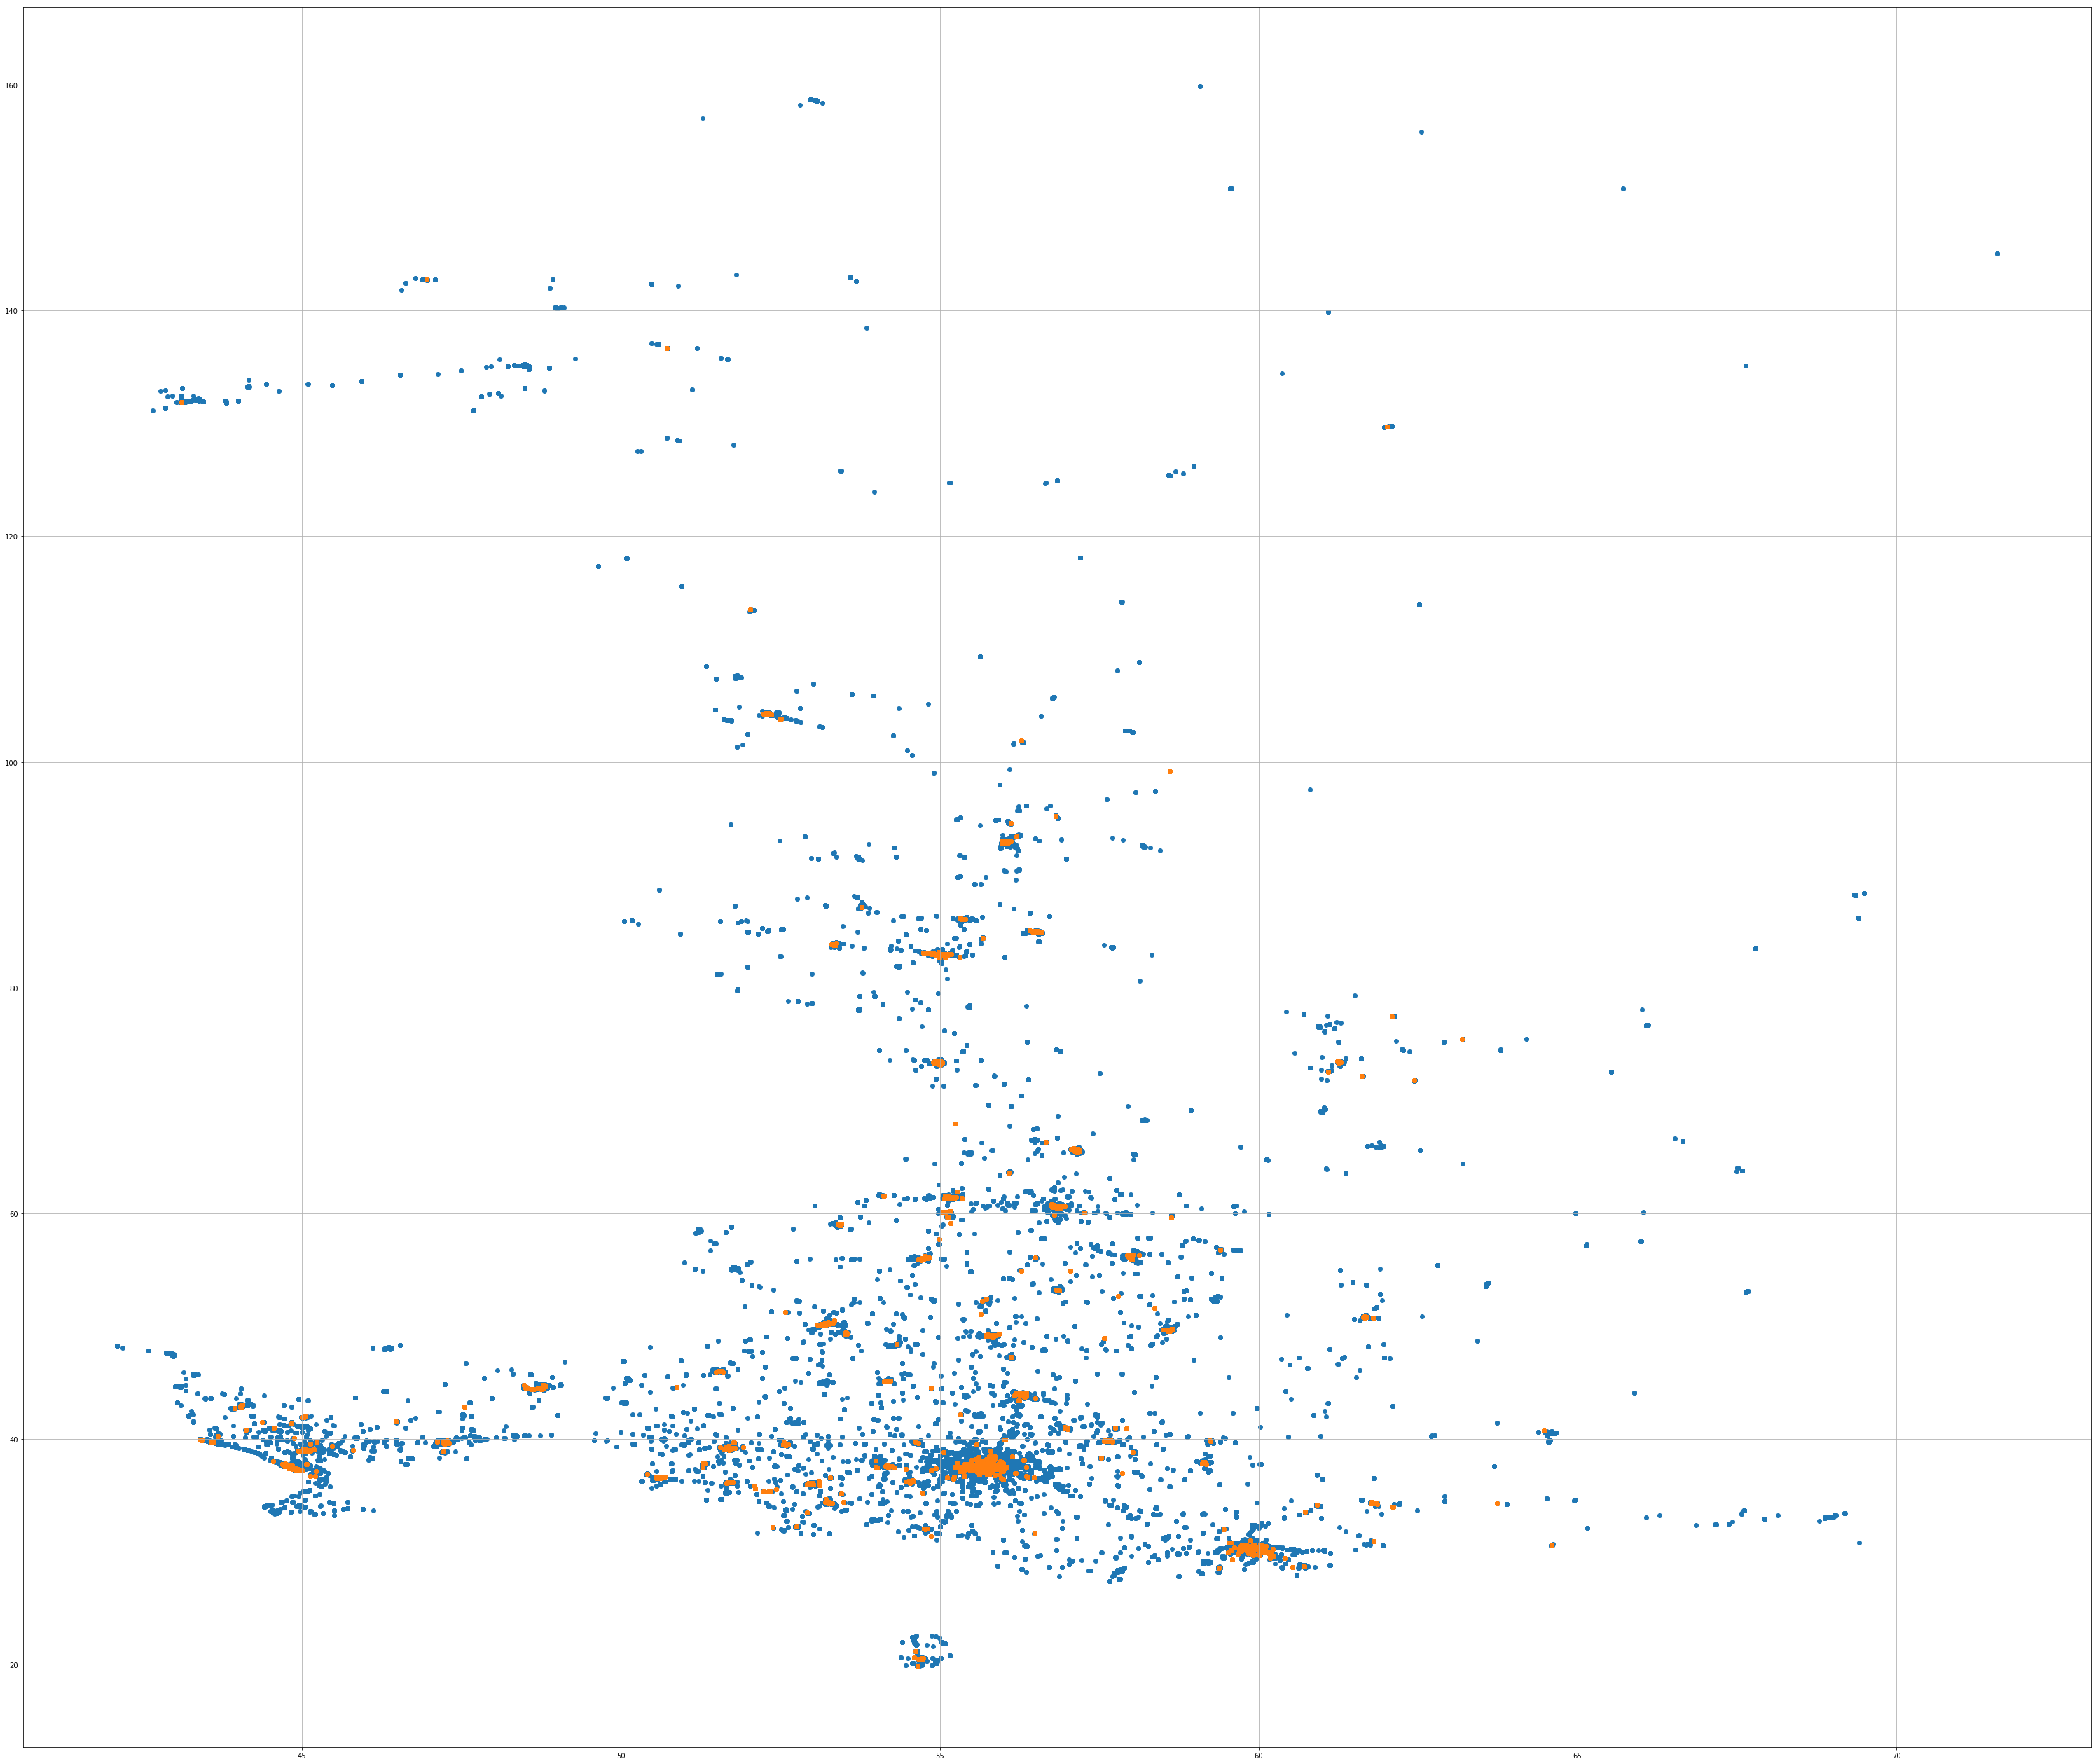

In [444]:
plt.scatter(train['pos_address_lat'], train['pos_address_lon'])
plt.scatter(train['work_add_lat'], train['work_add_lon'])
plt.grid(True)
plt.show()

In [445]:
del train, test

# Features

## Currency/Date

In [380]:
dt['currency'] = dt['currency'].fillna(-1).astype(np.int32)
dt.drop(dt[dt['transaction_date'].isnull()].index, axis = 0, inplace = True)
dt['transaction_date'] = dt['transaction_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

In [393]:
dt['weekday'] = dt['transaction_date'].dt.weekday.astype(np.int32)

In [394]:
ruholidays = pd.read_pickle('./add_data/Russian_holidays_16_17_18.pkl')
ruholidays['holiday_date'] = ruholidays['holiday_date'].apply(lambda x: datetime.datetime.combine(x, datetime.datetime.min.time()))
ruholidayslist = ruholidays['holiday_date'].tolist()
dt['holiday'] = dt['transaction_date'].apply(lambda x: 4 if x in ruholidayslist else 0)

## mcc

In [ ]:
dt['mcc'] = dt['mcc'].apply(lambda x: int(x.replace(',', ''))).astype(np.int32)

In [381]:
mcc_codes = pd.read_csv('./add_data/mcc_codes.csv', ',')
mcc_codes.fillna('-1', inplace=True)

In [362]:
for column in mcc_codes.columns:
    print(column, len(mcc_codes[column].unique()))

mcc 981
edited_description 722
combined_description 715
usda_description 706
irs_description 286
irs_reportable 6


In [383]:
mcc_codes.head()

,mcc,edited_description,combined_description,usda_description,irs_description,irs_reportable
0,742,Veterinary Services,Veterinary Services,Veterinary Services,Veterinary Services,Yes
1,763,Agricultural Co-operatives,Agricultural Co-operatives,Agricultural Co-operatives,Agricultural Cooperative,Yes
2,780,"Horticultural Services, Landscaping Services","Horticultural Services, Landscaping Services",Horticultural Services,Landscaping Services,Yes
3,1520,General Contractors-Residential and Commercial,General Contractors-Residential and Commercial,General Contractors-Residential and Commercial,General Contractors,Yes
4,1711,Air Conditioning Contractors – Sales and Insta...,Air Conditioning Contractors – Sales and Insta...,Air Conditioning Contractors – Sales and Insta...,"Heating, Plumbing, A/C",Yes


In [384]:
mcc_irs_des = {mcc_code_i[0]:mcc_code_i[1] for mcc_code_i in mcc_codes[['mcc', 'irs_description']].values.tolist()}
mcc_irs_rep = {mcc_code_i[0]:mcc_code_i[1] for mcc_code_i in mcc_codes[['mcc', 'irs_reportable']].values.tolist()}

In [385]:
dt['mcc_irs_des'] = dt['mcc'].apply(lambda x: mcc_irs_des[x])
dt['mcc_irs_rep'] = dt['mcc'].apply(lambda x: mcc_irs_rep[x])

In [407]:
dt['mcc_irs_des_f'] = dt['mcc_irs_des'].factorize()[0].astype(np.int32)
dt['mcc_irs_rep_f'] = dt['mcc_irs_rep'].factorize()[0].astype(np.int32)

## Country preprocess

In [386]:
iso_codes_l = pd.read_csv('./add_data/ISOcodes.csv', ';')[['2-let', '3-let']].values.tolist()

In [387]:
iso_codes_d = {country[0]:country[1] for country in iso_codes_l}

In [388]:
dt['country'] = dt['country'].apply(lambda x: x.replace(' ', ''))
dt['country'] = dt['country'].apply(lambda x: iso_codes_d[x] if len(x) < 3 else x)
dt['country_faq'] = dt['country'].factorize()[0].astype(np.int32)

## City preprocess

In [389]:
SPEC_SYMB = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '/', '*', '-', '(', ')', '%', '+', '_', 
             '>', '<', '=', ',', ', ', "'", '`', '  ',]
SPEC_ENDS = [' ', ' g']
SPEC_STRT = [' ', ]
def replace_symb(in_str):
    for symbol in SPEC_SYMB:
        in_str = in_str.replace(symbol, '')
        if len(in_str) > 1 and in_str[0] == ' ':
            in_str = in_str[1:]
        elif len(in_str) <= 1:
            return '-1'
        if len(in_str) > 1:
            for ending in SPEC_ENDS:
                if in_str.endswith(ending):
                    in_str = in_str[:-len(ending)]
        if len(in_str) > 1:
            for strtng in SPEC_ENDS:
                if in_str.startswith(strtng):
                    in_str = in_str[len(strtng):]
    return in_str.lower()

In [390]:
dt['city_str'] = dt['city'].apply(lambda x: replace_symb(str(x)))
dt['city_str_f'] = dt['city_str'].factorize()[0].astype(np.int32)

## Адрес pos и atm-транзакций к единообразному виду

In [399]:
dt['is_atm'] = (~dt['atm_address_lat'].isnull()).astype(np.int32)
dt['is_pos'] = (~dt['pos_address_lat'].isnull()).astype(np.int32)

dt['address_lat'] = dt['atm_address_lat'].fillna(0) + dt['pos_address_lat'].fillna(0)
dt['address_lon'] = dt['atm_address_lon'].fillna(0) + dt['pos_address_lon'].fillna(0)

dt.drop(['atm_address_lat','atm_address_lon','pos_address_lat','pos_address_lon'], axis = 1, inplace = True)
dt.drop(dt[((dt['address_lon'] == 0) & (dt['address_lon'] == 0))].index, axis = 0, inplace = True)

## Признаки is_home, is_work

In [400]:
lat = dt['home_add_lat'] - dt['address_lat']
lon = dt['home_add_lon'] - dt['address_lon']
dt['is_home'] = (np.sqrt((lat ** 2) + (lon ** 2)) <= 0.02).astype(np.int32)
dt['has_home'] = (~dt['home_add_lon'].isnull()).astype(np.int32)

lat = dt['work_add_lat'] - dt['address_lat']
lon = dt['work_add_lon'] - dt['address_lon']
dt['is_work'] = (np.sqrt((lat ** 2) + (lon ** 2)) <= 0.02).astype(np.int32)
dt['has_work'] = (~dt['work_add_lon'].isnull()).astype(np.int32)

dt.drop(['work_add_lat','work_add_lon','home_add_lat','home_add_lon'], axis = 1, inplace = True)

##  Категориальный признак для адреса

In [401]:
dt['address'] = dt['address_lat'].apply(lambda x: "%.02f" % x) + ';' + dt['address_lon'].apply(lambda x: "%.02f" % x)
dt['address'] = dt['address'].factorize()[0].astype(np.int32)

## Несколько абонентских фич

In [402]:
# количество транзакций каждого клиента
dt = dt.merge(dt.groupby('customer_id')['amount'].count().reset_index(name = 'tx'), how = 'left')
dt['tx'] = dt['tx'].astype(np.int32)

dt = dt.merge(dt.groupby(['customer_id','address'])['amount'].count().reset_index(name = 'tx_cust_addr'), how = 'left')
dt['tx_cust_addr'] = dt['tx_cust_addr'].astype(np.int32)

# какая часть транзакций клиента приходится на данный адрес
dt['ratio1'] = dt['tx_cust_addr'] / dt['tx']

# Вспомогательные функции

In [411]:
def _best(x):
    ret = None
    for col in ys:
        pred = ('pred:%s' % col)
        if pred in x:
            i = (x[pred].idxmax())
            cols = [pred,'address_lat','address_lon']
            if col in x:
                cols.append(col)
            tmp = x.loc[i,cols]
            tmp.rename({
                'address_lat':'%s:add_lat' % col,
                'address_lon':'%s:add_lon' % col,
            }, inplace = True)
            if ret is None:
                ret = tmp
            else:
                ret = pd.concat([ret, tmp])
    return ret

In [417]:
def predict_proba(dt, ys = ['is_home', 'is_work']):
    for col in ys:
        pred = ('pred:%s' % col)
        dt[pred] = model[col].predict_proba(dt[xs])[:,1]
    return dt.groupby('customer_id').apply(_best).reset_index()

In [413]:
def score(dt, ys = ['is_home', 'is_work']):
    dt_ret = predict_proba(dt, ys)
    mean = 0.0
    for col in ys:
        col_mean = dt_ret[col].mean()
        mean += col_mean
    if len(ys) == 2:
        mean = mean / len(ys)
    return mean

# Models

## Features/Target

In [419]:
fix_seed = 8123
xs = ['amount','currency','city_str_f','country_faq','mcc', 'mcc_irs_des_f', 'mcc_irs_rep_f', 
      'is_atm', 'is_pos','ratio1', 'holiday']
ys = ['is_home', 'is_work']

## Fit

In [430]:
reg_alpha = 0.5
reg_lambda = 0.4
model0 = {
    'is_home': xgb.XGBClassifier(n_estimators=1000, n_jobs=7, seed=fix_seed, 
                                         reg_alpha=reg_alpha, reg_lambda=reg_lambda),
    'is_work': xgb.XGBClassifier(n_estimators=1000, n_jobs=7, seed=fix_seed, 
                                         reg_alpha=reg_alpha, reg_lambda=reg_lambda),
}

In [425]:
model = {}

for col in ['is_home', 'is_work']:
    cust_train = dt[dt['is_train'] == 1].groupby('customer_id')[col.replace('is_','has_')].max()
    cust_train = cust_train[cust_train > 0].index
    cust_train, cust_valid = train_test_split(cust_train, test_size=0.1, shuffle=True, random_state=fix_seed)
    
    train = pd.DataFrame(cust_train, columns = ['customer_id']).merge(dt, how = 'left')
    valid = pd.DataFrame(cust_valid, columns = ['customer_id']).merge(dt, how = 'left')
    
    print ("Training:", col)
    clf = sklearn.base.clone(model0[col])
    clf.fit(train[xs], train[col], eval_metric = 'logloss', 
            eval_set = [(train[xs], train[col]), (valid[xs], valid[col])], verbose=10,
            early_stopping_rounds=50)
    model[col] = clf
    valid_score = score(valid, ys = [col])
    
    print ("Train accuracy:", score(train, ys = [col]))
    print ("Test accuracy:", valid_score)
    print ()

Training: is_home
[0]	validation_0-logloss:0.659666	validation_1-logloss:0.659704
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 50 rounds.
[10]	validation_0-logloss:0.520711	validation_1-logloss:0.522353
[20]	validation_0-logloss:0.492448	validation_1-logloss:0.496495
[30]	validation_0-logloss:0.483488	validation_1-logloss:0.488601
[40]	validation_0-logloss:0.479026	validation_1-logloss:0.485571
[50]	validation_0-logloss:0.475846	validation_1-logloss:0.482699
[60]	validation_0-logloss:0.473867	validation_1-logloss:0.481151
[70]	validation_0-logloss:0.472473	validation_1-logloss:0.480342
[80]	validation_0-logloss:0.471031	validation_1-logloss:0.479324
[90]	validation_0-logloss:0.469773	validation_1-logloss:0.479193
[100]	validation_0-logloss:0.468567	validation_1-logloss:0.479087
[110]	validation_0-logloss:0.467643	validation_1-logloss:0.478911
[120]	validation_0-logloss:0.46702	v

## Predict

In [426]:
cust_test = dt[dt['is_train'] == 0]['customer_id'].unique()
test = pd.DataFrame(cust_test, columns = ['customer_id']).merge(dt, how = 'left')

In [427]:
test = predict_proba(test)

In [428]:
test.rename(columns = {
        'customer_id':'_ID_',
        'is_home:add_lat': '_HOME_LAT_',
        'is_home:add_lon': '_HOME_LON_',
        'is_work:add_lat': '_WORK_LAT_',
        'is_work:add_lon': '_WORK_LON_'}, inplace = True)
test = test[['_ID_', '_WORK_LAT_', '_WORK_LON_', '_HOME_LAT_', '_HOME_LON_']]

# Submission

In [429]:
submission = submission.merge(test, how = 'left').fillna(0)
submission.to_csv('city_cou_norm.csv', index = False)